# Outlier Detection (Gaussian Toy Example)

In this notebook, we will demonstrate the basics of outlier detection in the context of anomaly detection. 
We will use simple Gaussian toy data to demonstrate the basic concepts. 

In the outlier detection version of anomaly detection, we train a model to learn what our background looks like
and then classify things as anomalous based on how 'disimilar' they look as compared to the background. 

Essentially this means we are defining events that have low probability density under the background to be anomalous. 
In this case, we are generating our own Gaussian toy data, so we know the true probability distribution of the background.
However, in realistic physics examples this is usually not the case. 
One must therefore train a machine learning model to learn the background probability distribution, or an equivalent proxy, from a sample of background events.

One common proxy used to learn the background distribution is a type of neural network called an autoencoder.
Autoencoders do not directly learn the probability distribution. Instead they are trained to take the input data, compress it down into some smaller representation
and decompress it back out to recover the original inputs. The idea is that by forcing the model to learn to compress the data, it will force it to learn its underlying structure.
If the model is trained only on background events, it should hopefully learn how to do this compression task for background events but not for signal events.
Therefore, there should be a larger difference between the model input and output on signal events. 
This difference, called the reconstruction loss, can therefore be used as an anomaly score.

Note that unlike weak supervision, we expect this type model to always be worse than a supervised classifier because it never sees signal events during the training.
However, it can usuaully be trained in an easier fashion, (because one only needs to find a sample of background events) and has a stable performance instead of varying depending on the amount of signal present. 

In [1]:
import sys, copy
from os.path import exists, join, dirname, realpath

import numpy as np
import scipy
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.generative_models.autoencoder import Autoencoder
from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier

In [2]:
#Pick the dimensionality of our dataset
n_dim = 10 #How many total dimensions of our data
n_signal_dim = 2 #How many dimensions of our signal are different from background


#Background is multi-dim Gaussian with zero mean, diagonal covariance of one
bkg_means = np.array([0.]*n_dim)
bkg_vars = np.ones(n_dim)
bkg_cov = np.diag(bkg_vars)
bkg_pdf = scipy.stats.multivariate_normal(bkg_means, bkg_cov)


#Signal is multi-dim Gaussian centered at 1 for 'signal like dimensions and 0 for the bkg-like dimensions
sig_means = np.array([2.5]*n_signal_dim + [0.] *(n_dim - n_signal_dim) )
sig_vars = np.array(n_signal_dim * [0.1] + [1.0]* (n_dim - n_signal_dim))
sig_cov = np.diag(sig_vars)
sig_pdf = scipy.stats.multivariate_normal(sig_means, sig_cov)

verbose = 0


In [3]:
#Data for training of autoencoder classifer
n_bkg = 100000
bkg_events_train = bkg_pdf.rvs(size = n_bkg )


#Data for training of supervised classifer
n_sup = 10000
sig_events_sup = sig_pdf.rvs(size = n_sup)
bkg_events_sup = bkg_pdf.rvs(size = n_sup)

x_sup = np.append(sig_events_sup, bkg_events_sup, axis = 0)
y_sup = np.append(np.ones(n_sup, dtype = np.int8), np.zeros(n_sup, dtype =np.int8))

x_sup, y_sup = shuffle(x_sup, y_sup, random_state = 42)
x_sup_train, x_sup_val, y_sup_train, y_sup_val = train_test_split(x_sup, y_sup, test_size = 0.2, random_state = 42)

#Data for testing
n_test = 50000
sig_events_test = sig_pdf.rvs(size = n_test//10)
bkg_events_test = bkg_pdf.rvs(size = n_test)

x_test = np.append(sig_events_test, bkg_events_test, axis = 0)
y_test = np.append(np.ones(n_test//10, dtype = np.int8), np.zeros(n_test, dtype =np.int8))



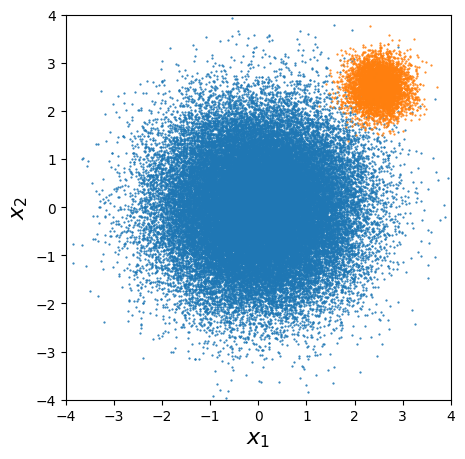

In [4]:
# Simple scatter plot of the first two dimensions of our data, background is in blue, signal is in orange
plt.figure(figsize = (5,5))
plt.scatter(bkg_events_test[:,0],bkg_events_test[:,1],s=0.3,color='C0')
plt.scatter(sig_events_test[:,0],sig_events_test[:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()


In [5]:
#AE model

#Pick size of compressed representation (latent)
latent_size = 4
layers = [n_dim, 32, 16, latent_size, 16, 32, n_dim]

ae_model = Autoencoder(n_inputs=n_dim, layers = layers, val_split = 0.1,
                        early_stopping=True, epochs=3, verbose=True)
ae_model.fit(bkg_events_train)


Epoch: 0


Train loss: 0.835873: 100%|██████████| 100000/100000 [00:02<00:00, 49766.19it/s]


Validation loss: 0.7801463554429886

Epoch: 1


Train loss: 0.762505: 100%|██████████| 100000/100000 [00:02<00:00, 49260.20it/s]


Validation loss: 0.7504982863698164

Epoch: 2


Train loss: 0.746253: 100%|██████████| 100000/100000 [00:02<00:00, 44275.32it/s]


Validation loss: 0.7410220681401469


Autoencoder(early_stopping=True, epochs=3, layers=[10, 32, 16, 4, 16, 32, 10],
            n_inputs=10, val_split=0.1, verbose=True)

In [14]:
#Do a quick check of the performance of the autoencoder as a classifier 

#predict_proba method computes MSE loss which we use as 'anomaly score' for each event 
y_test_ae = ae_model.predict_proba(x_test)
auc_ae = roc_auc_score(y_test, y_test_ae)

print("AE AUC %.3F" % auc_ae)

AE AUC 0.967


In [15]:
#Do a quick check of the performance of the true bkg pdf as a classifier 
x_test_pdf = bkg_pdf.pdf(x_test)
#One over bkg probability as outlier score 
y_test_pdf = 1./x_test_pdf

auc_pdf = roc_auc_score(y_test, y_test_pdf)
print("bkg PDF AUC %.3F" % auc_pdf)

bkg PDF AUC 0.951


In [16]:
#Train a supervised model for comparison

sup_model = NeuralNetworkClassifier(n_inputs=n_dim,
                                    early_stopping=True, epochs=100,
                                    verbose=True)
sup_model.fit(x_sup_train, y_sup_train, x_sup_val, y_sup_val)


Epoch: 0


Train loss: 0.186917: 100%|██████████| 16000/16000 [00:00<00:00, 38340.85it/s]


Validation loss: 0.033663027395959944

Epoch: 1


Train loss: 0.023890: 100%|██████████| 16000/16000 [00:00<00:00, 28855.70it/s]


Validation loss: 0.026277413497155067

Epoch: 2


Train loss: 0.017957: 100%|██████████| 16000/16000 [00:00<00:00, 30896.41it/s]


Validation loss: 0.01974475908355089

Epoch: 3


Train loss: 0.015014: 100%|██████████| 16000/16000 [00:00<00:00, 44716.02it/s]


Validation loss: 0.015647270360204857

Epoch: 4


Train loss: 0.012958: 100%|██████████| 16000/16000 [00:00<00:00, 48425.28it/s]


Validation loss: 0.017426439702830976

Epoch: 5


Train loss: 0.011045: 100%|██████████| 16000/16000 [00:00<00:00, 48873.45it/s]


Validation loss: 0.012839416835049633

Epoch: 6


Train loss: 0.009474: 100%|██████████| 16000/16000 [00:00<00:00, 42190.35it/s]


Validation loss: 0.011672683045617305

Epoch: 7


Train loss: 0.009890: 100%|██████████| 16000/16000 [00:00<00:00, 51110.08it/s]


Validation loss: 0.013185920492105652

Epoch: 8


Train loss: 0.009202: 100%|██████████| 16000/16000 [00:00<00:00, 50882.95it/s]


Validation loss: 0.015858498074521776

Epoch: 9


Train loss: 0.008318: 100%|██████████| 16000/16000 [00:00<00:00, 38063.84it/s]


Validation loss: 0.011882487104230677

Epoch: 10


Train loss: 0.008521: 100%|██████████| 16000/16000 [00:00<00:00, 38766.44it/s]


Validation loss: 0.011979605530541448

Epoch: 11


Train loss: 0.007263: 100%|██████████| 16000/16000 [00:00<00:00, 37233.41it/s]


Validation loss: 0.011718473966539023

Epoch: 12


Train loss: 0.007307: 100%|██████████| 16000/16000 [00:00<00:00, 33914.59it/s]


Validation loss: 0.012429107764546643

Epoch: 13


Train loss: 0.008509: 100%|██████████| 16000/16000 [00:00<00:00, 40053.85it/s]


Validation loss: 0.01649929978611908

Epoch: 14


Train loss: 0.007386: 100%|██████████| 16000/16000 [00:00<00:00, 40176.43it/s]


Validation loss: 0.010389072332145588

Epoch: 15


Train loss: 0.005663: 100%|██████████| 16000/16000 [00:00<00:00, 44835.82it/s]


Validation loss: 0.010735394201219606

Epoch: 16


Train loss: 0.006847: 100%|██████████| 16000/16000 [00:00<00:00, 52129.46it/s]


Validation loss: 0.033025931416432286

Epoch: 17


Train loss: 0.006810: 100%|██████████| 16000/16000 [00:00<00:00, 51976.00it/s]


Validation loss: 0.010384940937001375

Epoch: 18


Train loss: 0.007248: 100%|██████████| 16000/16000 [00:00<00:00, 36649.30it/s]


Validation loss: 0.012861159677868272

Epoch: 19


Train loss: 0.005546: 100%|██████████| 16000/16000 [00:00<00:00, 40692.26it/s]


Validation loss: 0.012761950876210904

Epoch: 20


Train loss: 0.005626: 100%|██████████| 16000/16000 [00:00<00:00, 44968.70it/s]


Validation loss: 0.014181796603224939

Epoch: 21


Train loss: 0.005961: 100%|██████████| 16000/16000 [00:00<00:00, 58363.60it/s]


Validation loss: 0.01751362986578897

Epoch: 22


Train loss: 0.005832: 100%|██████████| 16000/16000 [00:00<00:00, 55651.13it/s]


Validation loss: 0.014348861355529152

Epoch: 23


Train loss: 0.005118: 100%|██████████| 16000/16000 [00:00<00:00, 54949.30it/s]


Validation loss: 0.01309624691020872

Epoch: 24


Train loss: 0.005565: 100%|██████████| 16000/16000 [00:00<00:00, 56330.10it/s]


Validation loss: 0.014093838613916887

Epoch: 25


Train loss: 0.004801: 100%|██████████| 16000/16000 [00:00<00:00, 53001.67it/s]


Validation loss: 0.014559671224560589

Epoch: 26


Train loss: 0.004339: 100%|██████████| 16000/16000 [00:00<00:00, 53184.98it/s]


Validation loss: 0.013244152616834981

Epoch: 27


Train loss: 0.004785: 100%|██████████| 16000/16000 [00:00<00:00, 53806.28it/s]


Validation loss: 0.014191039539582562
Early stopping at epoch 27


AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

In [9]:
#Do a quick check of the performance of the supervised classifier 
y_test_sup = sup_model.predict(x_test)
auc_sup = roc_auc_score(y_test, y_test_sup)

print("Supervised AUC %.3F" % auc_sup)

Supervised AUC 0.999


In [10]:
def make_roc_plot(y_pred, y_true, colors = None, logy = True, labels = None, fname = ""):

    fs = 18
    fs_leg = 16
    sic_max = 10.
    
    sics = []
    tprs = []
    fprs = []

    for idx in range(len(y_pred)):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred[idx])
    
        auc_ = roc_auc_score(y_true, y_pred[idx])

        #guard against division by 0
        fpr = np.clip(fpr, 1e-8, 1.)
        fprs.append(fpr)
        sics.append( tpr / np.sqrt(fpr))
        tprs.append(tpr)

        lbl = 'auc %.3f' % auc_
        clr = 'navy'
        if(labels is not None): labels[idx] = labels[idx] + ", auc=%.3f" % auc_
        if(colors is not None): clr = colors[idx]

        print(lbl)

        

    #ROC plot
    plt.figure(figsize=(10,10))
    for i in range(len(fprs)):
        plt.plot(tprs[i], 1./fprs[i], lw=2, color=colors[i], label=labels[i])
        
    plt.xlim([0, 1.0])
    plt.xlabel('Signal Efficiency', fontsize=fs) 
    plt.yscale('log')
    plt.ylim([1., 1e4])
    plt.ylabel('Bkg Rejection Rate (1/ Bkg. Eff)', fontsize=fs)
    plt.legend(loc="upper right", fontsize = fs_leg)

   
    #SIC plot
    plt.figure(figsize=(10,10))
    for i in range(len(fprs)):
        plt.plot(fprs[i], sics[i], lw=2, color=colors[i], label=labels[i])

    
    plt.xlim([0, 1.0])
    plt.xlabel('Bkg Efficiency', fontsize=fs)
    plt.ylim([0., sic_max])
    plt.ylabel('Significance Improvement (SIC)', fontsize=fs)
    plt.legend(loc="upper right", fontsize = fs_leg)

        



auc 0.999
auc 0.967
auc 0.951


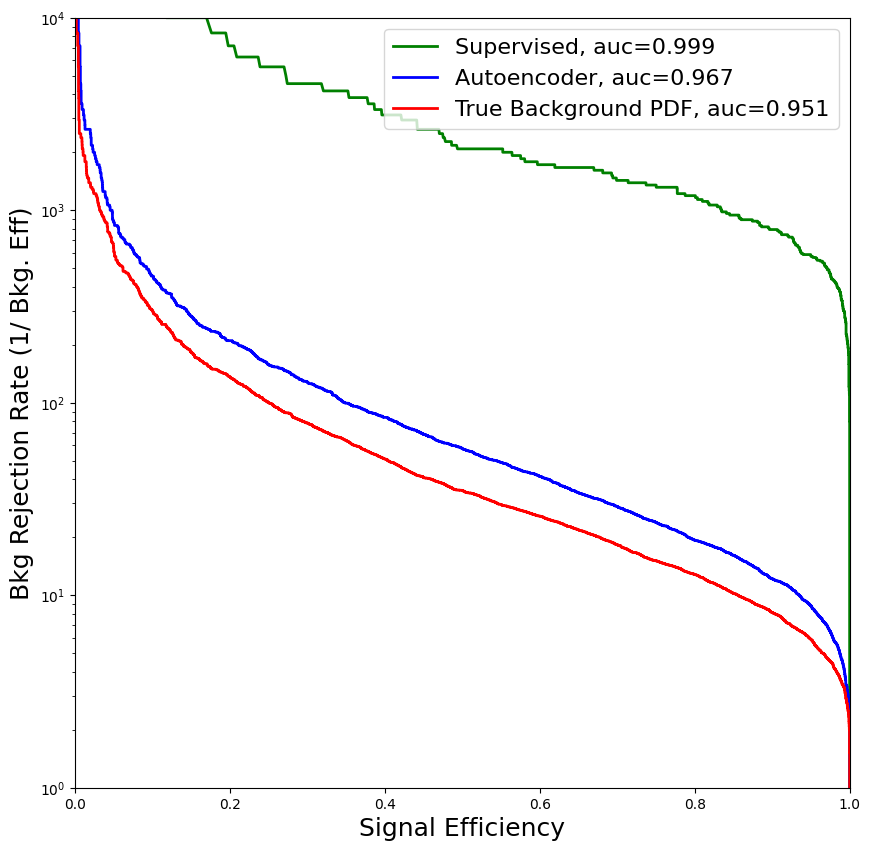

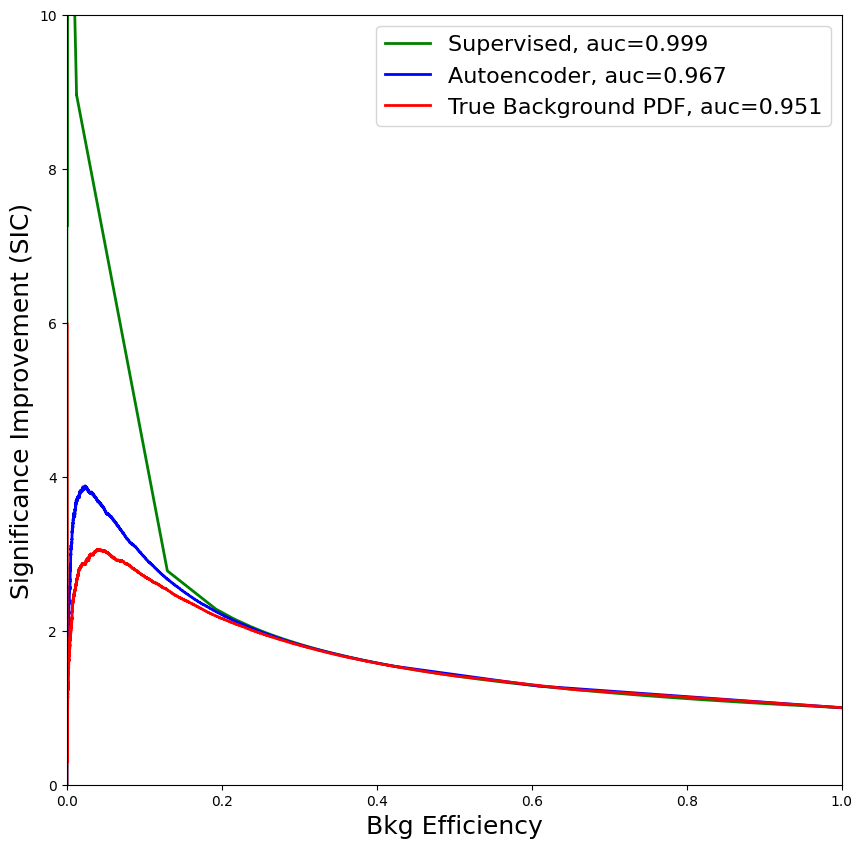

In [11]:
make_roc_plot([y_test_sup, y_test_ae, y_test_pdf], y_test, colors = ['green', 'blue', 'red'], 
              labels = ['Supervised', 'Autoencoder',  'True Background PDF'])
plt.show()